# Time series

This is an analysis of how we can model time data to work with machine learning algorithms


## Data creation
First import the libraries that we should need to use:
- numpy
- matplotlib 
- pandas
- sklearn

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy as cp
import time

from sklearn.linear_model import LinearRegression

Then we need **time series** data. For that we will create random data with numpy.

In [2]:
N = 600

t = np.arange(0, N, 1).reshape(-1,1)
t = np.array([t[i] + np.random.rand(1)/4 for i in range(len(t))])
t = np.array([t[i] - np.random.rand(1)/7 for i in range(len(t))])
t = np.array(np.round(t, 2))

x1 = np.round((np.random.random(N) * 5).reshape(-1,1), 2)
x2 = np.round((np.random.random(N) * 5).reshape(-1,1), 2)
x3 = np.round((np.random.random(N) * 5).reshape(-1,1), 2)

n = np.round((np.random.random(N) * 2).reshape(-1,1), 2)

y = np.array([((np.log(np.abs(2 + x1[t])) - x2[t-1]**2) + 0.02*x3[t-3]*np.exp(x1[t-1])) for t in range(len(t))])
y = np.round(y+n, 2)

Let's plot this: 

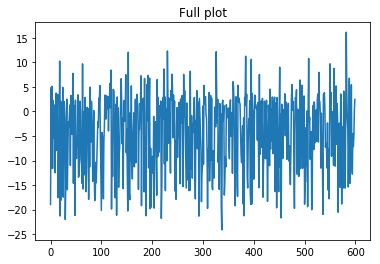

In [3]:
# Full plot
plt.plot(y)
plt.title('Full plot')
plt.show()

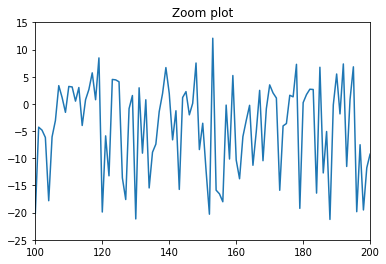

In [4]:
# Zoomed plot
plt.plot(y)
plt.title('Zoom plot')
plt.axis([100,200, -25, 15])
plt.show()

In [5]:
dataset = pd.DataFrame(np.concatenate((t, x1, x2, x3, y), axis=1), 
                       columns=['t', 'x1', 'x2', 'x3', 'y'])

deltaT = np.array([(dataset.t[i + 1] - dataset.t[i]) for i in range(len(dataset)-1)])
deltaT = np.concatenate((np.array([0]), deltaT))

dataset.insert(1, '∆t', deltaT)
dataset.head(3)

,t,∆t,x1,x2,x3,y
0,-0.08,0.00,4.88,1.17,2.61,-18.96
1,1.03,1.11,3.05,3.84,0.96,4.85
2,2.11,1.08,4.57,1.79,4.16,-11.61


In [6]:
size_training = 450
trainset = dataset.iloc[:size_training]
testset = dataset.iloc[size_training:]
len(testset)

150

In [7]:
class WindowSlider(object):
    
    def __init__(self, window_size = 5):        
        '''
        Window Slider object
        ====================
        w: window_size - number of time steps to look back
        o: offset between last reading and temperature
        r: response_size - number of time steps to predict
        l: maximum length to slide - (#observation - w)
        p: final predictors - (#predictors * w)
        '''
        self.w = window_size
        self.o = 0
        self.r = 1       
        self.l = 0
        self.p = 0
        self.names = []
        
    def re_init(self, arr):
        '''
        Helper function to initializate to 0 a vector
        '''
        arr = np.cumsum(arr)
        return arr - arr[0]
                

    def collect_windows(self, X, window_size=5, offset=0, previous_y=False):
        '''
        Input: X is the input matrix, each column is a variable
        Returns: diferent mappings window-output
        '''
        cols = len(list(X)) - 1
        N = len(X)
        
        self.o = offset
        self.w = window_size
        self.l = N - (self.w + self.r) + 1
        if not previous_y: self.p = cols * (self.w)
        if previous_y: self.p = (cols + 1) * (self.w)
        
        # Create the names of the variables in the window
        # Check first if we need to create that for the response itself
        if previous_y: x = cp.deepcopy(X)
        if not previous_y: x = X.drop(X.columns[-1], axis=1)  
        
        for j, col in enumerate(list(x)):        
                
            for i in range(self.w):
                
                name = col + ('(%d)' % (i+1))
                self.names.append(name)
        
        # Incorporate the timestamps where we want to predict
        for k in range(self.r):
            
            name = '∆t' + ('(%d)' % (self.w + k + 1))
            self.names.append(name)
            
        self.names.append('Y')
                
        df = pd.DataFrame(np.zeros(shape=(self.l, (self.p + self.r + 1))), 
                          columns=self.names)
        
        # Populate by rows in the new dataframe
        for i in range(self.l):
            
            slices = np.array([])
            
            # Flatten the lags of predictors
            for p in range(x.shape[1]):
            
                line = X.values[i:self.w + i, p]
                # Reinitialization at every window for ∆T
                if p == 0: line = self.re_init(line)
                    
                # Concatenate the lines in one slice    
                slices = np.concatenate((slices, line)) 
 
            # Incorporate the timestamps where we want to predict
            line = np.array([self.re_init(X.values[i:i+self.w+self.r, 0])[-1]])
            y = np.array(X.values[self.w + i + self.r - 1, -1]).reshape(1,)
            slices = np.concatenate((slices, line, y))
            
            # Incorporate the slice to the cake (df)
            df.iloc[i,:] = slices
            
        return df

In [8]:



w = 5
train_constructor = WindowSlider()
train_windows = train_constructor.collect_windows(trainset.iloc[:,1:], 
                                                  previous_y=False)

test_constructor = WindowSlider()
test_windows = test_constructor.collect_windows(testset.iloc[:,1:],
                                                previous_y=False)

train_constructor_y_inc = WindowSlider()
train_windows_y_inc = train_constructor_y_inc.collect_windows(trainset.iloc[:,1:], 
                                                  previous_y=True)

test_constructor_y_inc = WindowSlider()
test_windows_y_inc = test_constructor_y_inc.collect_windows(testset.iloc[:,1:],
                                                previous_y=True)

test_windows.head(3)

,∆t(1),∆t(2),∆t(3),∆t(4),∆t(5),x1(1),x1(2),x1(3),x1(4),x1(5),...,x2(3),x2(4),x2(5),x3(1),x3(2),x3(3),x3(4),x3(5),∆t(6),Y
0,0.0,1.04,1.99,2.88,3.86,4.11,3.88,1.57,1.85,4.73,...,1.74,4.95,1.62,4.49,1.42,1.14,1.63,1.08,5.09,1.48
1,0.0,0.95,1.84,2.82,4.05,3.88,1.57,1.85,4.73,2.29,...,4.95,1.62,1.59,1.42,1.14,1.63,1.08,1.11,4.91,0.23
2,0.0,0.89,1.87,3.10,3.96,1.57,1.85,4.73,2.29,2.30,...,1.62,1.59,3.61,1.14,1.63,1.08,1.11,3.85,4.88,-9.60


In [9]:
# ________________ Y_pred = current Y ________________ 
bl_trainset = cp.deepcopy(trainset)
bl_testset = cp.deepcopy(testset)

bl_y = pd.DataFrame(bl_testset['y'])
bl_y_pred = bl_y.shift(periods=1)

bl_residuals = bl_y_pred - bl_y
bl_rmse = np.sqrt(np.sum(np.power(bl_residuals,2)) / len(bl_residuals))
print('RMSE = %.2f' % bl_rmse)
print('Time to train = 0 seconds')
## RMSE = 11.28

RMSE = 10.41
Time to train = 0 seconds


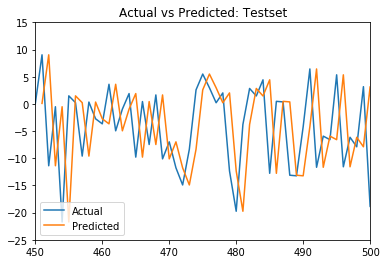

In [10]:
# 1 plot
plt.plot(bl_y, label='Actual')
plt.plot(bl_y_pred, label='Predicted')
plt.legend(loc='lower left')
plt.title('Actual vs Predicted: Testset')
plt.axis([450,500, -25, 15])
plt.show()

In [11]:
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()
lr_model.fit(trainset.iloc[:,:-1], trainset.iloc[:,-1])

t0 = time.time()
lr_y = testset['y'].values
lr_y_fit = lr_model.predict(trainset.iloc[:,:-1])
lr_y_pred = lr_model.predict(testset.iloc[:,:-1])
tF = time.time()

lr_residuals = lr_y_pred - lr_y
lr_rmse = np.sqrt(np.sum(np.power(lr_residuals,2)) / len(lr_residuals))
print('RMSE = %.2f' % lr_rmse)
print('Time to train = %.2f seconds' % (tF - t0))
## RMSE = 8.61 
## Time to train = 0.00 seconds

RMSE = 7.65
Time to train = 0.00 seconds


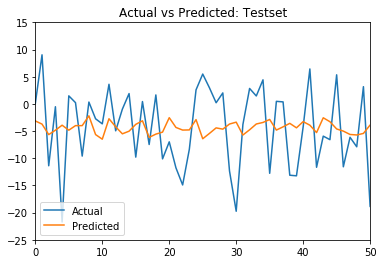

In [12]:
# 2 plot
plt.plot(lr_y, label='Actual')
plt.plot(lr_y_pred, label='Predicted')
plt.legend(loc='lower left')
plt.axis([0,50, -25, 15])
plt.title('Actual vs Predicted: Testset')
plt.show()

In [13]:
# ___________ MULTIPLE LINEAR REGRESSION ON WINDOWS ___________ 
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()
lr_model.fit(train_windows.iloc[:,:-1], train_windows.iloc[:,-1])

t0 = time.time()
lr_y = test_windows['Y'].values
lr_y_fit = lr_model.predict(train_windows.iloc[:,:-1])
lr_y_pred = lr_model.predict(test_windows.iloc[:,:-1])
tF = time.time()

lr_residuals = lr_y_pred - lr_y
lr_rmse = np.sqrt(np.sum(np.power(lr_residuals,2)) / len(lr_residuals))
print('RMSE = %.2f' % lr_rmse)
print('Time to train = %.2f seconds' % (tF - t0))
## RMSE = 3.84
## Time to train = 0.00 seconds

RMSE = 2.25
Time to train = 0.01 seconds


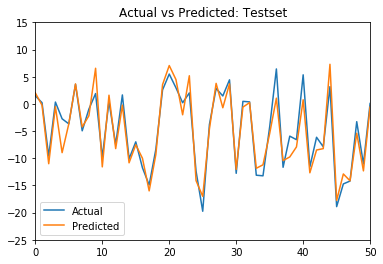

In [14]:
# 3 plot
plt.plot(lr_y, label='Actual')
plt.plot(lr_y_pred, label='Predicted')
plt.legend(loc='lower left')
plt.axis([0,50, -25, 15])
plt.title('Actual vs Predicted: Testset')
plt.show()

In [ ]:
#https://towardsdatascience.com/ml-approaches-for-time-series-4d44722e48fe